## Spark Streaming - Plotando o gráfico de sentimento

### Author: Leandro Correa; Versão: 1.0.0-beta; Update: 01-02-2022


In [1]:
import time
from watchdog.observers import Observer
from watchdog.events import PatternMatchingEventHandler
import types
#!pip install money_parser
from money_parser import price_str
import re
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import pdb
from IPython import display
#pdb.set_trace()

%matplotlib inline
plt.rcParams['animation.html'] = 'jshtml'

In [2]:
#variavel com o nome da pesquisa
global search_term 
# Diretorio onde o projeto está sendo executado
PATH = re.sub("notebooks","",os.getcwd())
# Aqruivo gerado contendo o nome do termo usado na busca do spark streaming
OUTPUT = PATH + 'data/term/output.txt'
# Diretorio onde sera registrado os resultados da analise do spark streaming
LISTENER = PATH + 'data/record'

# Variáveis globais
bad_felling = []
good_feling = []
timecolect = []
timecolect2 = []
list_consumed_files = []
list_visited_dir = []

In [3]:
def get_parameters(line):
    for l in line:
        global good_feling
        global bad_felling
        global timecolect
        global timecolect2
        aux = l.split(", ")
        if len(aux) > 2:
            if price_str(aux[1]) == '1':
                good_feling.append(int(price_str(aux[2])))
                bad_felling.append(int(price_str(aux[4])))
            else:
                good_feling.append(int(price_str(aux[4])))
                bad_felling.append(int(price_str(aux[2])))
            timestm = l[2:16]
            timestm2 = l[8:16]
            timecolect.append(str(timestm))
            timecolect2.append(str(timestm2))
        
            x = [x for x in range(1,len(timecolect)+1)]
            plt.rcParams["figure.figsize"] = (14.5,8)
            fig = plt.figure()
            ax = fig.add_subplot(111)
            title = 'Análise de sentimento do termo ' + search_term
            plt.suptitle(title, fontsize=18)
            plt.xticks(rotation=90)

            index = np.argsort(timecolect)
            
            timecolect = [timecolect[i] for i in index]
            timecolect2 = [timecolect2[i] for i in index]
            bad_felling = [bad_felling[i] for i in index]
            good_feling = [good_feling[i] for i in index]
            
            # Numero maximo de pontos no gráfico
            slide = 40
            
            if len(good_feling) > slide:
                good = good_feling[-slide:]
                bad = bad_felling[-slide:]
                tiime = timecolect2[-slide:]
                tstv= 'l1'
            else:
                good = good_feling
                bad = bad_felling
                tiime = timecolect2
                tstv= 'l2'

            plt.ylabel('Numero de twittes')
            plt.xlabel('Tempo (H:M)')
            ax.plot(tiime,good, c='b', label='good feeling',linewidth=4.0)
            ax.plot(tiime, bad, c='r', label='bad feeling' ,linewidth=4.0)

            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.14),
                      fancybox=True, shadow=True, ncol=5)
            
            display.display(plt.gcf())
            display.clear_output(wait=True)

            time.sleep(0.1)

In [4]:
def on_created(event):
    global LISTENER
    global list_consumed_files
    global list_visited_dir

    record = os.listdir(LISTENER)
    if record:
        index = np.argsort(record)
        record = [record[i] for i in index]
        for r in record: 
            if r not in list_visited_dir:
                path = LISTENER + '/' + r + '/'
                files = [x for x in os.listdir(path) if x[0] != '.' and x != '_SUCCESS']
                for i in files:
                    file_path = path + i
                    if os.path.isdir(file_path) == False:
                        list_visited_dir.append(r)
                        f = open(file_path, "r")
                        line = f.readlines()
                        if file_path not in list_consumed_files:
                            get_parameters(line)
                            list_consumed_files.append(file_path)
    '''
    if timecolect:
        print("good:")
        print(good_feling)
        print("bad:")
        print(bad_felling)
        print("time:")
        print(timecolect)
    '''
    

In [5]:
patterns = "*"
ignore_patterns = ""
ignore_directories = False
case_sensitive = True
my_event_handler = PatternMatchingEventHandler(patterns, ignore_patterns, ignore_directories, case_sensitive)

In [6]:
my_event_handler.on_created = on_created

In [7]:
with open(OUTPUT) as json_file:
    output = json.load(json_file)
search_term = output['search_term']


In [8]:
LISTENER

'/home/leandro/Workspace/mm/dsml-twitter-real-time/data/record'

In [9]:
go_recursively = True
my_observer = Observer()
my_observer.schedule(my_event_handler, LISTENER, recursive=go_recursively)

<ObservedWatch: path=/home/leandro/Workspace/mm/dsml-twitter-real-time/data/record, is_recursive=True>

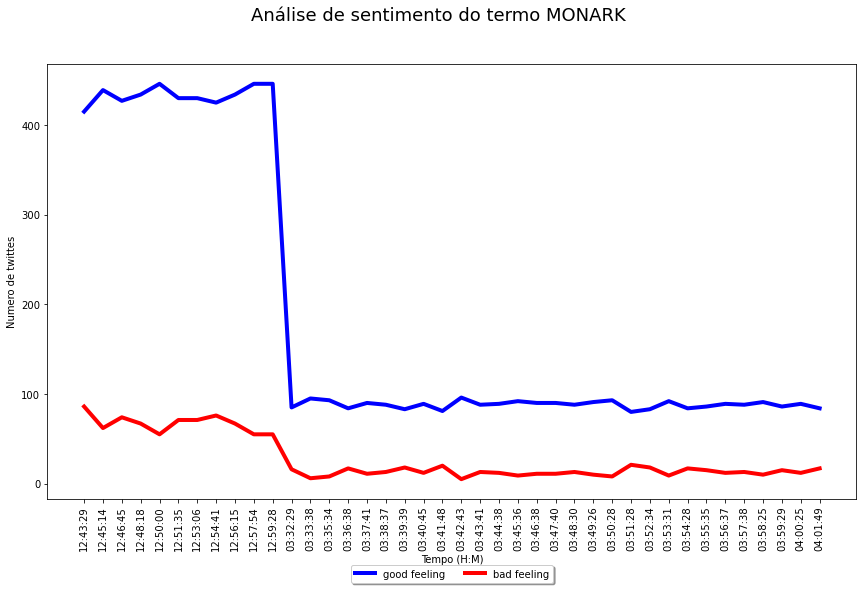

In [ ]:
my_observer.start()
try:
    while True:
        time.sleep(5)
except KeyboardInterrupt:
    my_observer.stop()